# 1. Setup

## 1-1. Library Setup

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from keras.utils import np_utils
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Dense, Flatten, Input
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.metrics import AUC

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1506297030804848372
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 16154099712
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 11441281464287470489
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
 xla_global_id: 416903419]

In [3]:
!nvidia-smi

Fri Dec 17 17:55:12 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    32W / 250W |    375MiB / 16280MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


## 1-2. parameter setup

In [5]:
basemodel = 'Xception'
image_size = 128
image_channels = 3
batch_size = 64
num_epochs = 100
class_num = 5
None_patience_num = 30
imagenet_patience_num = 20
S_all_labels = "S0", "S1", "S2", "S3", "S4"
T_all_labels = "T0", "T1", "T2", "T3", "T4"

#base_path = ''
base_path = 'gdrive/My Drive/Research_5_2_1/'

path_data = base_path + 'data_numpy/'
path_model_result = base_path + 'model_result/1 - Base_model_result/' + basemodel + '/'

In [6]:
S_model_name_imagenet = 'S_' + basemodel + '_imagenet'
S_model_name_None = 'S_' + basemodel + '_None'
T_model_name_imagenet = 'T_' + basemodel + '_imagenet'
T_model_name_None = 'T_' + basemodel + '_None'

print(S_model_name_None, S_model_name_imagenet, T_model_name_None, T_model_name_imagenet)

basemodel_list=[S_model_name_imagenet, S_model_name_None, T_model_name_imagenet, T_model_name_None]
basemodel_list

S_Xception_None S_Xception_imagenet T_Xception_None T_Xception_imagenet


['S_Xception_imagenet',
 'S_Xception_None',
 'T_Xception_imagenet',
 'T_Xception_None']

In [7]:
def createDirectory(name): 
    try: 
        if not os.path.exists(name): 
            os.makedirs(path_model_result + name) 
    except OSError: 
        print("Error: Failed to create the directory.")  
        
for i in basemodel_list:
    createDirectory(i)

# 2. Data Load and Image Check

## 2-1. Data Load

In [8]:
xTrain_S = np.load(path_data + 'xTrain_S.npy')
xValid_S = np.load(path_data + 'xValid_S.npy')
xTest_S = np.load(path_data + 'xTest_S.npy')

yTrain_S = np.load(path_data + 'yTrain_S.npy')
yValid_S = np.load(path_data + 'yValid_S.npy')
yTest_S = np.load(path_data + 'yTest_S.npy')

xTrain_T = np.load(path_data + 'xTrain_T.npy')
xValid_T = np.load(path_data + 'xValid_T.npy')
xTest_T = np.load(path_data + 'xTest_T.npy')

yTrain_T = np.load(path_data + 'yTrain_T.npy')
yValid_T = np.load(path_data + 'yValid_T.npy')
yTest_T = np.load(path_data + 'yTest_T.npy')

In [9]:
print(xTrain_S.shape, yTrain_S.shape)
print(xValid_S.shape, yValid_S.shape)
print(xTest_S.shape, yTest_S.shape)
print()
print(xTrain_T.shape, yTrain_T.shape)
print(xValid_T.shape, yValid_T.shape)
print(xTest_T.shape, yTest_T.shape)

(2034, 128, 128, 3) (2034, 1)
(678, 128, 128, 3) (678, 1)
(678, 128, 128, 3) (678, 1)

(2274, 128, 128, 3) (2274, 1)
(758, 128, 128, 3) (758, 1)
(758, 128, 128, 3) (758, 1)


In [10]:
xTrain_S = xTrain_S.astype('float32')/255
xValid_S = xValid_S.astype('float32')/255
xTest_S = xTest_S.astype('float32')/255

yTrain_S = np_utils.to_categorical(yTrain_S, class_num)
yValid_S = np_utils.to_categorical(yValid_S, class_num)
yTest_S = np_utils.to_categorical(yTest_S, class_num)

xTrain_T = xTrain_T.astype('float32')/255
xValid_T = xValid_T.astype('float32')/255
xTest_T = xTest_T.astype('float32')/255

yTrain_T = np_utils.to_categorical(yTrain_T, class_num)
yValid_T = np_utils.to_categorical(yValid_T, class_num)
yTest_T = np_utils.to_categorical(yTest_T, class_num)

In [11]:
print(xTrain_S.shape, yTrain_S.shape)
print(xValid_S.shape, yValid_S.shape)
print(xTest_S.shape, yTest_S.shape)
print()
print(xTrain_T.shape, yTrain_T.shape)
print(xValid_T.shape, yValid_T.shape)
print(xTest_T.shape, yTest_T.shape)

(2034, 128, 128, 3) (2034, 5)
(678, 128, 128, 3) (678, 5)
(678, 128, 128, 3) (678, 5)

(2274, 128, 128, 3) (2274, 5)
(758, 128, 128, 3) (758, 5)
(758, 128, 128, 3) (758, 5)


## 2-2. Image Check

xTrain_S image Numbers :  2034
xTrain_S image Numbers // 10 :  203
11


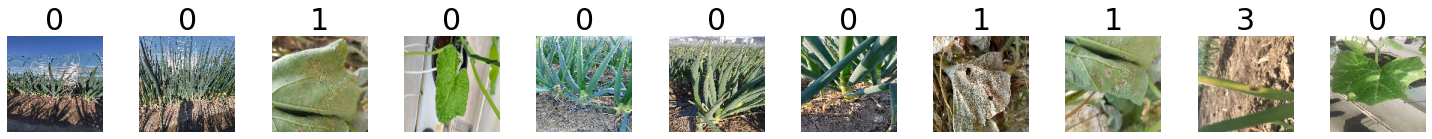

In [12]:
temp_S_a = len(xTrain_S)
print("xTrain_S image Numbers : ", temp_S_a)
temp_S_b = temp_S_a//10
print("xTrain_S image Numbers // 10 : ", temp_S_b)
temp_S_c = 0
for i in range(0, temp_S_a, temp_S_b):
    temp_S_c += 1
print(temp_S_c)


c=0
plt.figure(figsize=(20,3))
for i in range(0, temp_S_a, temp_S_b):
    plt.subplot(1, temp_S_c, c+1)
    plt.imshow(xTrain_S[i])
    plt.title(yTrain_S[i].argmax(),fontsize=30)
    plt.tight_layout()
    plt.axis('off')
    c+=1
plt.show()

xTrain_S image Numbers :  2274
xTrain_S image Numbers // 10 :  227
11


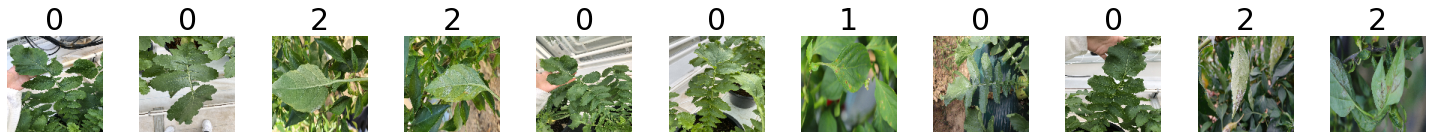

In [13]:
temp_T_a = len(xTrain_T)
print("xTrain_S image Numbers : ", temp_T_a)
temp_T_b = temp_T_a//10
print("xTrain_S image Numbers // 10 : ", temp_T_b)
temp_T_c = 0
for i in range(0, temp_T_a, temp_T_b):
    temp_T_c += 1
print(temp_T_c)


c=0
plt.figure(figsize=(20,3))
for i in range(0,temp_T_a,temp_T_b):
    plt.subplot(1, temp_T_c, c+1)
    plt.imshow(xTrain_T[i])
    plt.title(yTrain_T[i].argmax(),fontsize=30)
    plt.tight_layout()
    plt.axis('off')
    c+=1
plt.show()

# 3. Network Setting and Training

## 3-1. Network Setting

In [14]:
def feature_extractor_None(inp):
    base_model=tf.keras.applications.Xception (
                include_top=False, weights=None, input_tensor=inp)
    input = base_model.input
    out = base_model.layers[-1].output
    feature_output = tf.keras.layers.GlobalAveragePooling2D(name='feature')(out)
    return feature_output


def classifier_None(feature_output):
    out = feature_output
    out = Dense(128, activation="relu")(out)
    out = Dense(32, activation="relu")(out)
    classifier_output = Dense(class_num, activation="softmax", name="classifier_output")(out)
    return classifier_output


def model_None():
    inp = Input(shape=(image_size, image_size, image_channels))   
    feature_output = feature_extractor_None(inp)
    classifier_output = classifier_None(feature_output)
    model = Model(inputs=inp, outputs=classifier_output)
    return model

In [15]:
def feature_extractor_imagenet(inp):
    base_model=tf.keras.applications.Xception (
                include_top=False, weights='imagenet', input_tensor=inp)
    input = base_model.input
    out = base_model.layers[-1].output
    feature_output = tf.keras.layers.GlobalAveragePooling2D(name='feature')(out)
    return feature_output


def classifier_imagenet(feature_output):
    out = feature_output
    out = Dense(128, activation="relu")(out)
    out = Dense(32, activation="relu")(out)
    classifier_output = Dense(class_num, activation="softmax", name="classifier_output")(out)
    return classifier_output


def model_imagenet():
    inp = Input(shape=(image_size, image_size, image_channels))   
    feature_output = feature_extractor_imagenet(inp)
    classifier_output = classifier_imagenet(feature_output)
    model = Model(inputs=inp, outputs=classifier_output)
    return model

In [16]:
#plot_model(model_None())
#plot_model(model_imagenet())

## 3-2. Source Domain Training - weights=None

In [17]:
S_basemodel_None=model_None()
#S_basemodel_None.summary()

In [18]:
S_basemodel_None.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=None_patience_num, restore_best_weights=True)

S_basemodel_None_main =S_basemodel_None.fit(xTrain_S, yTrain_S, 
                    epochs=num_epochs, batch_size=batch_size, validation_data=(xValid_S, yValid_S), callbacks=[ES])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(S_basemodel_None_main.history["val_accuracy"]) * 100))

Epoch 1/100
32/32 [==============================] - 22s 309ms/step - loss: 0.7656 - accuracy: 0.7217 - val_loss: 1.5973 - val_accuracy: 0.1770
Epoch 2/100
32/32 [==============================] - 8s 249ms/step - loss: 0.3411 - accuracy: 0.8712 - val_loss: 1.6006 - val_accuracy: 0.1770
Epoch 3/100
32/32 [==============================] - 8s 249ms/step - loss: 0.2522 - accuracy: 0.9046 - val_loss: 1.6066 - val_accuracy: 0.1770
Epoch 4/100
32/32 [==============================] - 8s 249ms/step - loss: 0.2621 - accuracy: 0.9027 - val_loss: 1.6132 - val_accuracy: 0.1386
Epoch 5/100
32/32 [==============================] - 8s 249ms/step - loss: 0.1800 - accuracy: 0.9425 - val_loss: 1.6270 - val_accuracy: 0.1770
Epoch 6/100
32/32 [==============================] - 8s 248ms/step - loss: 0.1273 - accuracy: 0.9543 - val_loss: 1.6032 - val_accuracy: 0.1770
Epoch 7/100
32/32 [==============================] - 8s 248ms/step - loss: 0.1272 - accuracy: 0.9597 - val_loss: 1.5885 - val_accuracy: 0.177

In [19]:
S_basemodel_None_df = pd.DataFrame(S_basemodel_None_main.history)
S_basemodel_None_df.to_csv( path_model_result + S_model_name_None + '/' + S_model_name_None + '_df.csv' )
S_basemodel_None_df

,loss,accuracy,val_loss,val_accuracy
0,0.765637,0.721731,1.597298,0.176991
1,0.341147,0.871190,1.600611,0.176991
2,0.252169,0.904621,1.606572,0.176991
3,0.262149,0.902655,1.613161,0.138643
4,0.179983,0.942478,1.626970,0.176991
...,...,...,...,...
57,0.043167,0.989184,3.159291,0.705015
58,0.020131,0.992625,2.972526,0.706490
59,0.044701,0.983776,0.259197,0.938053
60,0.017052,0.996067,0.213773,0.966077


Minimum validation loss: 0.12951046228408813
Maximum validation accuracy: 0.9675516486167908


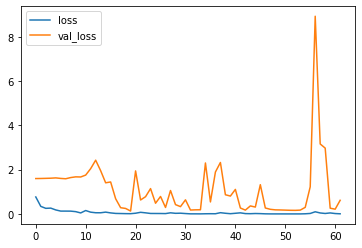

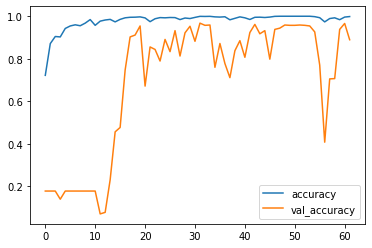

In [20]:
S_basemodel_None_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig(path_model_result + S_model_name_None + '/' + S_model_name_None + '_loss,val_loss.png')
S_basemodel_None_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(path_model_result + S_model_name_None + '/' + S_model_name_None + '_accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(S_basemodel_None_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(S_basemodel_None_df['val_accuracy'].max()))

In [21]:
print("Evaluate on test data")
S_basemodel_None_results = S_basemodel_None.evaluate(xTest_S, yTest_S)
print("test loss, test acc:", S_basemodel_None_results)

Evaluate on test data
22/22 [==============================] - 1s 33ms/step - loss: 0.1807 - accuracy: 0.9602
test loss, test acc: [0.18066661059856415, 0.9601770043373108]


In [22]:
S_basemodel_None_pred_Y = S_basemodel_None.predict(xTest_S, verbose = True)

22/22 [==============================] - 1s 26ms/step


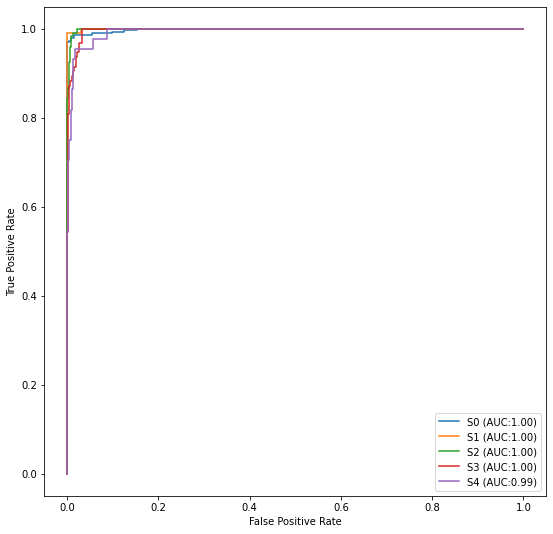

In [23]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(S_all_labels):
    fpr, tpr, thresholds = roc_curve(yTest_S[:,idx].astype(int), S_basemodel_None_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig( path_model_result + S_model_name_None + '/' + S_model_name_None +'_TESTSET_AUC.png' )

## 3-3. Source Domain Training - weights='imagenet'

In [24]:
S_basemodel_imagenet=model_imagenet()
#S_basemodel_None.summary()

83697664/83683744 [==============================] - 0s 0us/step


In [25]:
S_basemodel_imagenet.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=imagenet_patience_num, restore_best_weights=True)

S_basemodel_imagenet_main =S_basemodel_imagenet.fit(xTrain_S, yTrain_S, 
                    epochs=num_epochs, batch_size=batch_size, validation_data=(xValid_S, yValid_S), callbacks=[ES])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(S_basemodel_imagenet_main.history["val_accuracy"]) * 100))

Epoch 1/100
32/32 [==============================] - 13s 286ms/step - loss: 0.4730 - accuracy: 0.8530 - val_loss: 7.4758 - val_accuracy: 0.6770
Epoch 2/100
32/32 [==============================] - 8s 251ms/step - loss: 0.1467 - accuracy: 0.9523 - val_loss: 1.3860 - val_accuracy: 0.8363
Epoch 3/100
32/32 [==============================] - 8s 252ms/step - loss: 0.0882 - accuracy: 0.9754 - val_loss: 0.5704 - val_accuracy: 0.9159
Epoch 4/100
32/32 [==============================] - 8s 249ms/step - loss: 0.0576 - accuracy: 0.9848 - val_loss: 1.4505 - val_accuracy: 0.8673
Epoch 5/100
32/32 [==============================] - 8s 249ms/step - loss: 0.0763 - accuracy: 0.9774 - val_loss: 1.0076 - val_accuracy: 0.8142
Epoch 6/100
32/32 [==============================] - 8s 251ms/step - loss: 0.0548 - accuracy: 0.9848 - val_loss: 0.8279 - val_accuracy: 0.9366
Epoch 7/100
32/32 [==============================] - 8s 252ms/step - loss: 0.0559 - accuracy: 0.9853 - val_loss: 0.2753 - val_accuracy: 0.960

In [26]:
S_basemodel_imagenet_df = pd.DataFrame(S_basemodel_imagenet_main.history)
S_basemodel_imagenet_df.to_csv( path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet + '_df.csv' )
S_basemodel_imagenet_df

,loss,accuracy,val_loss,val_accuracy
0,0.472995,0.852999,7.475767,0.676991
1,0.146726,0.952311,1.385985,0.836283
2,0.088164,0.975418,0.570394,0.915929
3,0.057579,0.984759,1.450490,0.867257
4,0.076272,0.977384,1.007563,0.814159
5,0.054762,0.984759,0.827933,0.936578
6,0.055928,0.985251,0.275265,0.960177
7,0.035734,0.988692,0.051406,0.979351
8,0.018299,0.993117,0.474483,0.932153
9,0.028543,0.994592,1.617921,0.824484


Minimum validation loss: 0.051406051963567734
Maximum validation accuracy: 0.9882006049156189


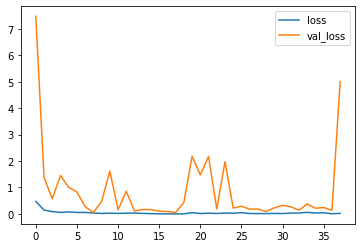

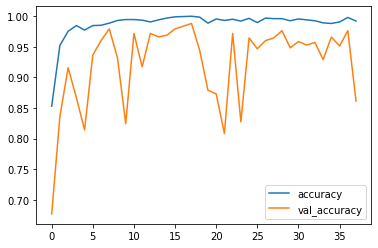

In [27]:
S_basemodel_imagenet_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig(path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet + '_loss,val_loss.png')
S_basemodel_imagenet_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet + '_accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(S_basemodel_imagenet_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(S_basemodel_imagenet_df['val_accuracy'].max()))

In [28]:
print("Evaluate on test data")
S_model_name_imagenet_results = S_basemodel_imagenet.evaluate(xTest_S, yTest_S)
print("test loss, test acc:", S_model_name_imagenet_results)

Evaluate on test data
22/22 [==============================] - 1s 29ms/step - loss: 0.0568 - accuracy: 0.9838
test loss, test acc: [0.056796252727508545, 0.983775794506073]


In [29]:
S_model_name_imagenet_pred_Y = S_basemodel_imagenet.predict(xTest_S, verbose = True)

22/22 [==============================] - 1s 26ms/step


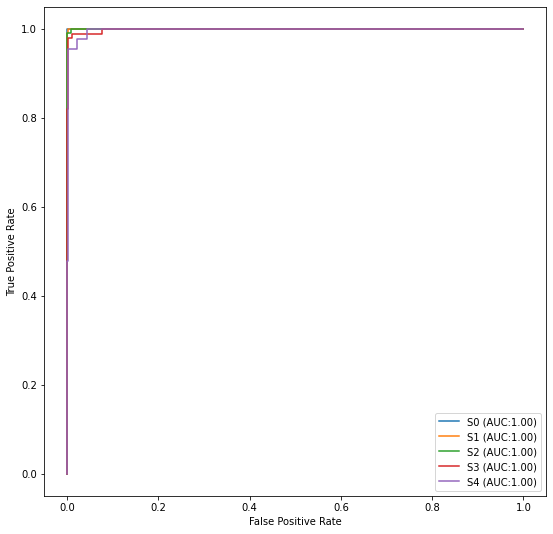

In [30]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(S_all_labels):
    fpr, tpr, thresholds = roc_curve(yTest_S[:,idx].astype(int), S_model_name_imagenet_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig( path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet +'_TESTSET_AUC.png' )

## 3-4. Target Domain Training - weights=None

In [31]:
T_basemodel_None=model_None()
#S_basemodel_None.summary()

In [32]:
T_basemodel_None.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=None_patience_num, restore_best_weights=True)

T_basemodel_None_main =T_basemodel_None.fit(xTrain_T, yTrain_T, 
                    epochs=num_epochs, batch_size=batch_size, validation_data=(xValid_T, yValid_T), callbacks=[ES])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(T_basemodel_None_main.history["val_accuracy"]) * 100))

Epoch 1/100
36/36 [==============================] - 14s 292ms/step - loss: 0.9610 - accuracy: 0.6253 - val_loss: 1.5996 - val_accuracy: 0.2111
Epoch 2/100
36/36 [==============================] - 9s 251ms/step - loss: 0.7225 - accuracy: 0.7269 - val_loss: 1.5972 - val_accuracy: 0.3958
Epoch 3/100
36/36 [==============================] - 9s 248ms/step - loss: 0.5617 - accuracy: 0.7894 - val_loss: 1.5915 - val_accuracy: 0.3958
Epoch 4/100
36/36 [==============================] - 9s 248ms/step - loss: 0.4699 - accuracy: 0.8254 - val_loss: 1.6085 - val_accuracy: 0.3958
Epoch 5/100
36/36 [==============================] - 9s 248ms/step - loss: 0.4073 - accuracy: 0.8443 - val_loss: 1.6035 - val_accuracy: 0.3958
Epoch 6/100
36/36 [==============================] - 9s 248ms/step - loss: 0.3480 - accuracy: 0.8624 - val_loss: 1.6583 - val_accuracy: 0.0580
Epoch 7/100
36/36 [==============================] - 9s 247ms/step - loss: 0.2847 - accuracy: 0.8835 - val_loss: 1.6753 - val_accuracy: 0.058

In [33]:
T_basemodel_None_df = pd.DataFrame(T_basemodel_None_main.history)
T_basemodel_None_df.to_csv( path_model_result + T_model_name_None + '/' + T_model_name_None + '_df.csv' )
T_basemodel_None_df

,loss,accuracy,val_loss,val_accuracy
0,0.961006,0.625330,1.599585,0.211082
1,0.722491,0.726913,1.597193,0.395778
2,0.561699,0.789358,1.591538,0.395778
3,0.469918,0.825418,1.608478,0.395778
4,0.407318,0.844327,1.603474,0.395778
...,...,...,...,...
90,0.012628,0.995602,3.414401,0.555409
91,0.027737,0.992084,1.053196,0.832454
92,0.031341,0.989006,5.799443,0.664908
93,0.016784,0.993404,1.645890,0.672823


Minimum validation loss: 0.763907253742218
Maximum validation accuracy: 0.8548812866210938


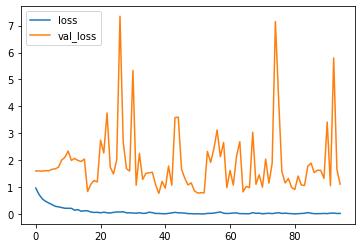

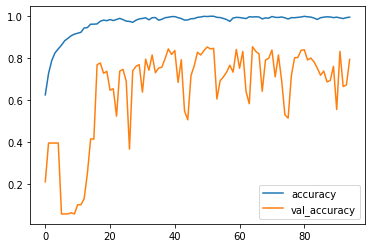

In [34]:
T_basemodel_None_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig(path_model_result + T_model_name_None + '/' + T_model_name_None + '_loss,val_loss.png')
T_basemodel_None_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(path_model_result + T_model_name_None + '/' + T_model_name_None + '_accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(T_basemodel_None_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(T_basemodel_None_df['val_accuracy'].max()))

In [35]:
print("Evaluate on test data")
T_basemodel_None_results = T_basemodel_None.evaluate(xTest_T, yTest_T)
print("test loss, test acc:", T_basemodel_None_results)

Evaluate on test data
24/24 [==============================] - 1s 35ms/step - loss: 0.8994 - accuracy: 0.8588
test loss, test acc: [0.8993837237358093, 0.8588390350341797]


In [36]:
T_basemodel_None_pred_Y = T_basemodel_None.predict(xTest_T, verbose = True)

24/24 [==============================] - 1s 26ms/step


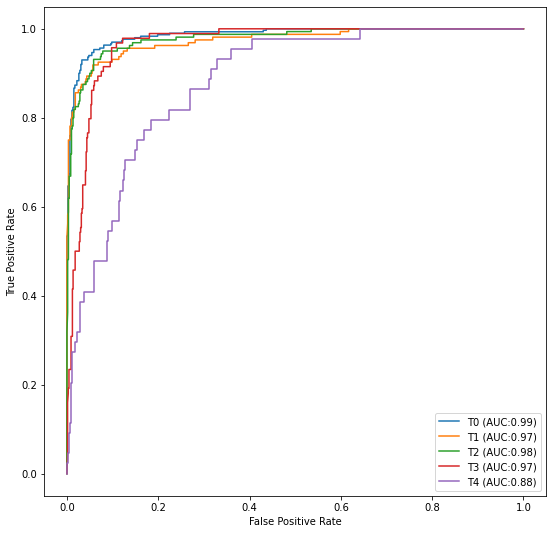

In [37]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(T_all_labels):
    fpr, tpr, thresholds = roc_curve(yTest_T[:,idx].astype(int), T_basemodel_None_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig( path_model_result + T_model_name_None + '/' + T_model_name_None + '_TESTSET_AUC.png' )

## 3-5. Target Domain Training - weights='imagenet'

In [38]:
T_basemodel_imagenet=model_imagenet()
#S_basemodel_None.summary()

In [39]:
T_basemodel_imagenet.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=imagenet_patience_num, restore_best_weights=True)

T_basemodel_imagenet_main =T_basemodel_imagenet.fit(xTrain_T, yTrain_T, 
                    epochs=num_epochs, batch_size=batch_size, validation_data=(xValid_T, yValid_T), callbacks=[ES])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(T_basemodel_imagenet_main.history["val_accuracy"]) * 100))

Epoch 1/100
36/36 [==============================] - 14s 274ms/step - loss: 0.5770 - accuracy: 0.7740 - val_loss: 5.0228 - val_accuracy: 0.6939
Epoch 2/100
36/36 [==============================] - 9s 247ms/step - loss: 0.2104 - accuracy: 0.9147 - val_loss: 8.4706 - val_accuracy: 0.6029
Epoch 3/100
36/36 [==============================] - 9s 248ms/step - loss: 0.1632 - accuracy: 0.9406 - val_loss: 2.8064 - val_accuracy: 0.6860
Epoch 4/100
36/36 [==============================] - 9s 247ms/step - loss: 0.1289 - accuracy: 0.9622 - val_loss: 6.2040 - val_accuracy: 0.6860
Epoch 5/100
36/36 [==============================] - 9s 250ms/step - loss: 0.1266 - accuracy: 0.9600 - val_loss: 0.9158 - val_accuracy: 0.8839
Epoch 6/100
36/36 [==============================] - 9s 250ms/step - loss: 0.0677 - accuracy: 0.9793 - val_loss: 0.4067 - val_accuracy: 0.8945
Epoch 7/100
36/36 [==============================] - 9s 248ms/step - loss: 0.0437 - accuracy: 0.9894 - val_loss: 0.7722 - val_accuracy: 0.858

In [40]:
T_basemodel_imagenet_df = pd.DataFrame(T_basemodel_imagenet_main.history)
T_basemodel_imagenet_df.to_csv( path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '_df.csv' )
T_basemodel_imagenet_df

,loss,accuracy,val_loss,val_accuracy
0,0.577039,0.773967,5.022810,0.693931
1,0.210358,0.914688,8.470607,0.602902
2,0.163177,0.940633,2.806419,0.686016
3,0.128917,0.962181,6.204001,0.686016
4,0.126611,0.959982,0.915832,0.883905
...,...,...,...,...
63,0.007168,0.996482,0.527011,0.902375
64,0.016772,0.996042,1.075431,0.836412
65,0.010468,0.997361,0.387097,0.923483
66,0.014734,0.996922,0.704005,0.902375


Minimum validation loss: 0.24475997686386108
Maximum validation accuracy: 0.9393140077590942


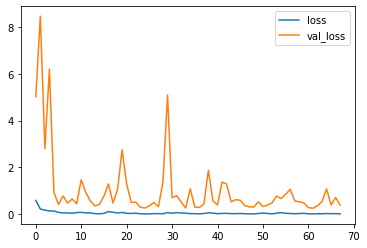

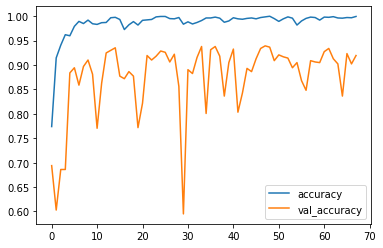

In [41]:
T_basemodel_imagenet_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig(path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '_loss,val_loss.png')
T_basemodel_imagenet_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '_accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(T_basemodel_imagenet_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(T_basemodel_imagenet_df['val_accuracy'].max()))

In [42]:
print("Evaluate on test data")
T_model_name_imagenet_results = T_basemodel_imagenet.evaluate(xTest_T, yTest_T)
print("test loss, test acc:", T_model_name_imagenet_results)

Evaluate on test data
24/24 [==============================] - 1s 29ms/step - loss: 0.3103 - accuracy: 0.9367
test loss, test acc: [0.3103088438510895, 0.936675488948822]


In [43]:
T_model_name_imagenet_pred_Y = T_basemodel_imagenet.predict(xTest_T, verbose = True)

24/24 [==============================] - 1s 26ms/step


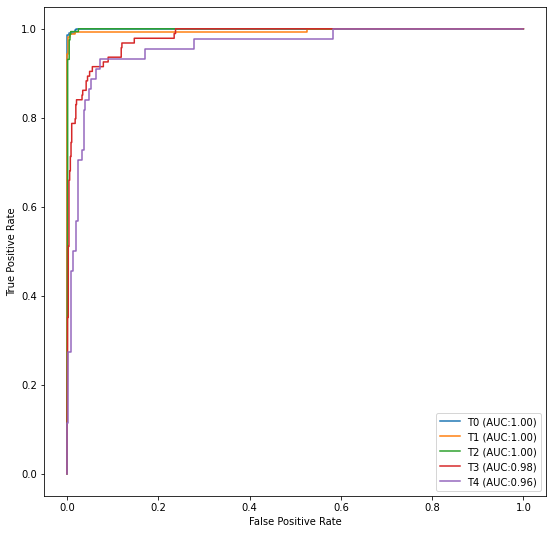

In [44]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(T_all_labels):
    fpr, tpr, thresholds = roc_curve(yTest_T[:,idx].astype(int), T_model_name_imagenet_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig( path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '_TESTSET_AUC.png' )

# 4. Result Report

In [45]:
print(S_model_name_None)
print("test loss, test acc:", S_basemodel_None_results)

S_Xception_None
test loss, test acc: [0.18066661059856415, 0.9601770043373108]


In [46]:
print(S_model_name_imagenet)
print("test loss, test acc:", S_model_name_imagenet_results)

S_Xception_imagenet
test loss, test acc: [0.056796252727508545, 0.983775794506073]


In [47]:
print(T_model_name_None)
print("test loss, test acc:", T_basemodel_None_results)

T_Xception_None
test loss, test acc: [0.8993837237358093, 0.8588390350341797]


In [48]:
print(T_model_name_imagenet)
print("test loss, test acc:", T_model_name_imagenet_results)

T_Xception_imagenet
test loss, test acc: [0.3103088438510895, 0.936675488948822]


# 5. Source Domain Training Model ↔ Target Domain Training Model 상호 Test Data Set 평가 

In [49]:
print( S_model_name_None + " →→→ Target Test")
S_basemodel_None_results_T = S_basemodel_None.evaluate(xTest_T, yTest_T)
print("test loss, test acc:", S_basemodel_None_results_T)

S_Xception_None →→→ Target Test
24/24 [==============================] - 1s 29ms/step - loss: 5.7184 - accuracy: 0.2995
test loss, test acc: [5.718364238739014, 0.29947230219841003]


In [50]:
print( S_model_name_imagenet + " →→→ Target Test")
S_model_name_imagenet_results_T = S_basemodel_imagenet.evaluate(xTest_T, yTest_T)
print("test loss, test acc:", S_model_name_imagenet_results_T)

S_Xception_imagenet →→→ Target Test
24/24 [==============================] - 1s 29ms/step - loss: 3.7574 - accuracy: 0.2625
test loss, test acc: [3.7573516368865967, 0.2625329792499542]


In [51]:
print( T_model_name_None + " →→→ Source Test")
T_basemodel_None_results_S = T_basemodel_None.evaluate(xTest_S, yTest_S)
print("test loss, test acc:", T_basemodel_None_results_S)

T_Xception_None →→→ Source Test
22/22 [==============================] - 1s 28ms/step - loss: 5.7972 - accuracy: 0.3879
test loss, test acc: [5.797185897827148, 0.3879055976867676]


In [52]:
print( T_model_name_imagenet + " →→→ Source Test")
T_model_name_imagenet_results_S = T_basemodel_imagenet.evaluate(xTest_S, yTest_S)
print("test loss, test acc:", T_model_name_imagenet_results_S)

T_Xception_imagenet →→→ Source Test
22/22 [==============================] - 1s 28ms/step - loss: 4.7648 - accuracy: 0.3053
test loss, test acc: [4.764809608459473, 0.3053097426891327]


# 6. Model Save 

In [53]:
S_basemodel_None.save( path_model_result + S_model_name_None + '/' + S_model_name_None + '.h5' )
S_basemodel_imagenet.save( path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet + '.h5' )
T_basemodel_None.save( path_model_result + T_model_name_None + '/' + T_model_name_None + '.h5' )
T_basemodel_imagenet.save( path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '.h5' )

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
